# Introduction 

This notebook shows the segmentation of clustering of neigbhorhood in Toronto city. The task is divided into three steps:

1. Scrape the neigborhood information of Toronto. 
2. Get the lattitude and longitude information of toronto, and visualize the neigbhorhood.
3. Get venues information for each neighborhood using the Foursquare API and do segmentation based on venues. 


In [8]:
import urllib
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import folium
import requests
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import display

# 1. Scrape the neigborhood information of Toronto

In [9]:
# get the web page information 
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page,'lxml')

# get the table information
table = soup.find("table", { "class" : "wikitable sortable" })
table_body = table.find('tbody')
data = []
rows = table_body.find_all('tr')

# get the contents data in the table
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values

Clean the data into a python DataFrame

In [10]:
# store the table data in the pandas dataframe. 

col_names = ['PostalCode', 'Borough', 'Neigbhorhood']
df_toronto = pd.DataFrame(columns = col_names)

for row in data:
    if len(row) > 2:
        df_toronto = df_toronto.append({'PostalCode': row[0], 'Borough':row[1], 'Neigbhorhood':row[2]}, ignore_index = True)
    elif len(row)<=1 or row[1] == 'Not assigned':
        continue
    elif len(row)==2:
        df_toronto = df_toronto.append({'PostalCode': row[0], 'Borough':row[1], 'Neigbhorhood':row[1]}, ignore_index = True)


There are not two rows with the same PostalCode

In [11]:
len(df_toronto.groupby(['PostalCode']).count()) == df_toronto.shape[0]

True

In [12]:
df_toronto.head()

,PostalCode,Borough,Neigbhorhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [13]:
print("The number of unique postal code in Toronto: {}".format(df_toronto.shape[0]))

The number of unique postal code in Toronto: 103


# 2. Get the lattitude and longitude information of toronto.

The target of this step is to use the geocoder based on postal code to get the lattitude and longitude information. However, the google API currently requires client credentials to enable it. In the following we skipped the process, and used the pre-stored coordinates. 

The command to use the geocoder to get the coordinates by a postal code is:
_g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))_


In [14]:
df_postal = pd.read_csv('Geospatial_Coordinates.csv')

In [15]:
df_toronto = df_toronto.merge(df_postal, left_on = 'PostalCode', right_on = 'Postal Code', how = 'left')
df_toronto.drop(['Postal Code'], axis = 1, inplace =True)

In [16]:
df_toronto

,PostalCode,Borough,Neigbhorhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Business reply mail Processing Centre,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


### Visualize the neigborhood in Toronto

In the following, I made two assumptions:
1. The neigborhood can be represented by the postal code. This can be quite true because there are quite a few neigborhood in each postal code as shown in the dataframe. 

2. To visualize Toronto, I assumed the coordinate of Toronto is the first coordinate in the df_toronto dataframe since we don't have the coordinate for Toronto. Using the coordinate of 'North York' can be fine because this Borough is actually in center of Toronto city. 

In [17]:
lattitude, longitude = df_toronto.loc[0, ['Latitude', 'Longitude']]

In [18]:
map_toronto = folium.Map(location = [lattitude, longitude], zoom_start = 10)

for lat, lng, borough, postalcode in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['PostalCode']):
    label = 'Zipcode {}: {}'.format(postalcode, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng],
    radius = 5,
    popup = label,
    color = 'blue',
    fill = True,
    fill_color = '#3189cc',
    fill_opacity = 0.7,
    parse_html = False).add_to(map_toronto)

display(map_toronto)

# 3. Get venues information for each neighborhood using the Foursquare API and do segmentation based on venues.

In [19]:
CLIENT_ID = 'AVZRVFTRP4A5HHIHF104VMAQ5JZHGRZW5M4QMX2PB2DBKSJJ' # your Foursquare ID
CLIENT_SECRET = '3GFE3NSV54SWNPXNUMNNVRPBPAQ55OZTLUJKU5ZZM2V4TYL0' # your Foursquare Secret
VERSION = '20200510' # Foursquare API version
LIMIT = 100 # Set the number of venues returned by the API is 100. 

__getNearbyVenues__ function get all the venues within the 4000 meters of a coordinate. 

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
toronto_venues = getNearbyVenues(names=df_toronto['PostalCode'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

In [22]:
toronto_venues.head()

,PostalCode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,M3A,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
2,M3A,43.753259,-79.329656,Island Foods,43.745866,-79.346035,Caribbean Restaurant
3,M3A,43.753259,-79.329656,Galleria Supermarket,43.753520,-79.349518,Supermarket
4,M3A,43.753259,-79.329656,Graydon Hall Manor,43.763923,-79.342961,Event Space


Check number of venues found for each neigborhood (assumed defined by the postal code). 

In [23]:
toronto_venues.groupby('PostalCode')['Venue'].count().sort_values()

PostalCode
M9V     83
M1C     85
M9M     98
M6C    100
M6B    100
      ... 
M3J    100
M3H    100
M3C    100
M4E    100
M9W    100
Name: Venue, Length: 103, dtype: int64

In [24]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 250 uniques categories.


### One-hot encoding the venues. 

In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['PostalCode'] = toronto_venues['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [26]:
toronto_onehot.shape

(10266, 251)

Check the frequency of each venue type in the neigborhood.

In [27]:
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
toronto_grouped.head()

,PostalCode,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,M1B,0.01,0.0,0.0,0.01,0.0,0.00,0.00,0.020000,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.00,0.00,0.020000,0.110000
1,M1C,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.011765,0.0,...,0.0,0.00,0.0,0.0,0.011765,0.0,0.00,0.00,0.023529,0.141176
2,M1E,0.00,0.0,0.0,0.01,0.0,0.00,0.00,0.020000,0.0,...,0.0,0.01,0.0,0.0,0.000000,0.0,0.01,0.01,0.000000,0.000000
3,M1G,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.010000,0.0,...,0.0,0.00,0.0,0.0,0.010000,0.0,0.01,0.00,0.000000,0.000000
4,M1H,0.00,0.0,0.0,0.01,0.0,0.01,0.02,0.010000,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.01,0.00,0.000000,0.000000


### Check most frequent venue categories in each neighborhood. 

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)


In [30]:
neighborhoods_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Zoo Exhibit,Coffee Shop,Pharmacy,Fast Food Restaurant,Gas Station,Sandwich Place,Pizza Place,Fried Chicken Joint,Restaurant,Bank
1,M1C,Zoo Exhibit,Park,Coffee Shop,Gas Station,Juice Bar,Bank,Pizza Place,Breakfast Spot,Zoo,Fried Chicken Joint
2,M1E,Coffee Shop,Bank,Sandwich Place,Pharmacy,Indian Restaurant,Park,Fried Chicken Joint,Gym,Gas Station,Fast Food Restaurant
3,M1G,Coffee Shop,Pizza Place,Fast Food Restaurant,Sandwich Place,Caribbean Restaurant,Pharmacy,Burger Joint,Restaurant,Pub,Park
4,M1H,Coffee Shop,Pizza Place,Sandwich Place,Fast Food Restaurant,Bank,Caribbean Restaurant,Indian Restaurant,Restaurant,Park,Fried Chicken Joint


### Get segmentation and clustering of neighborhood in Toronto city

we set the cluster number of 

In [31]:
toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

ks = range(3, 15)
costs = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 0)
    pred = kmeans.fit_predict(toronto_grouped_clustering)
    cost = kmeans.inertia_
    costs.append(cost)

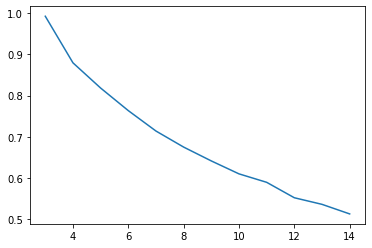

In [32]:
plt.plot(ks, costs)
plt.show()

#### We find that the neighborhoods are quite diverse. Hard to find an optimal value for k clusters by albow method. For simplicity, I am going to use kclusters = 4.

In [33]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state = 0).fit(toronto_grouped_clustering)  

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neigbhorhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3,Middle Eastern Restaurant,Supermarket,Caribbean Restaurant,Grocery Store,Italian Restaurant,Japanese Restaurant,Burger Joint,Bakery,Coffee Shop,Liquor Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,3,Park,Supermarket,Coffee Shop,Burger Joint,Middle Eastern Restaurant,Grocery Store,Sports Bar,Liquor Store,Discount Store,Steakhouse
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Café,Neighborhood,Brewery,Restaurant,Pizza Place,French Restaurant,Ice Cream Shop,Hotel
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3,Coffee Shop,Italian Restaurant,Vietnamese Restaurant,Café,Bakery,Park,Bank,Liquor Store,Sandwich Place,Breakfast Spot
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Park,Bakery,Café,Restaurant,Spa,Dessert Shop,Indian Restaurant,Plaza,Supermarket


In [35]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[lattitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

In [36]:
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [37]:
toronto_grouped.head()

,Cluster Labels,PostalCode,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,2,M1B,0.01,0.0,0.0,0.01,0.0,0.00,0.00,0.020000,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.00,0.00,0.020000,0.110000
1,2,M1C,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.011765,...,0.0,0.00,0.0,0.0,0.011765,0.0,0.00,0.00,0.023529,0.141176
2,2,M1E,0.00,0.0,0.0,0.01,0.0,0.00,0.00,0.020000,...,0.0,0.01,0.0,0.0,0.000000,0.0,0.01,0.01,0.000000,0.000000
3,2,M1G,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.010000,...,0.0,0.00,0.0,0.0,0.010000,0.0,0.01,0.00,0.000000,0.000000
4,2,M1H,0.00,0.0,0.0,0.01,0.0,0.01,0.02,0.010000,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.01,0.00,0.000000,0.000000


In [38]:
temp = toronto_grouped[toronto_grouped['Cluster Labels'] == 0].drop(
    ['Cluster Labels', 'PostalCode'], axis =1).sum().reset_index()
temp.columns = ['venue','freq']
temp = temp.round({'freq': 2})
temp.sort_values('freq', ascending=False).reset_index(drop=True).head()

,venue,freq
0,Park,3.07
1,Café,2.60
2,Coffee Shop,2.16
3,Italian Restaurant,1.57
4,Bakery,1.31


In [39]:
num_top_venues = 5

df_freq = pd.DataFrame(columns = ['venue'])
for k in range(kclusters):

    temp = toronto_grouped[toronto_grouped['Cluster Labels'] == k].drop(
        ['Cluster Labels', 'PostalCode'], axis =1).sum().reset_index()
    temp.columns = ['venue','freq']
    temp = temp.round({'freq': 2})
    tmp = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    df_freq = df_freq.merge(tmp, on = 'venue', how = 'outer')
    df_freq.rename(columns = {'freq': 'Cluster_'+str(k)}, inplace =True)

In [40]:
df_freq.fillna(value = 0, inplace = True)
df_freq.set_index('venue', inplace = True)

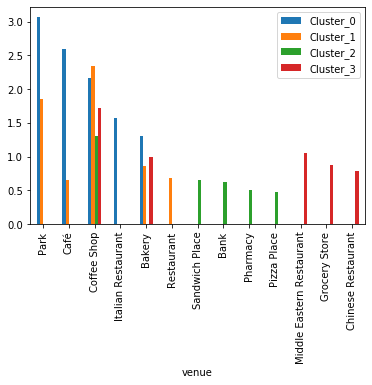

In [41]:
df_freq.plot(kind = 'bar')